In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, model_selection, preprocessing, pipeline, impute, feature_selection
from sklearn.experimental import enable_iterative_imputer
from itertools import chain, combinations, product
import math
import time

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=UserWarning)


import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

%matplotlib inline
from pyAgrum.lib.bn2roc import showROC
from pyAgrum.lib.bn2roc import showPR
from pyAgrum.lib.bn2roc import showROC_PR

import networkx as nx
import graphviz

In [2]:
data = pd.read_csv("insurance.csv")
data

,GoodStudent,Age,SocioEcon,RiskAversion,VehicleYear,ThisCarDam,RuggedAuto,Accident,MakeModel,DrivQuality,...,HomeBase,AntiTheft,PropCost,OtherCarCost,OtherCar,MedCost,Cushioning,Airbag,ILiCost,DrivHist
0,False,Adult,Prole,Adventurous,Older,Moderate,EggShell,Mild,Economy,Poor,...,City,False,TenThou,Thousand,True,Thousand,Poor,False,Thousand,Many
1,False,Senior,Prole,Cautious,Current,None,Football,None,Economy,Normal,...,City,True,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero
2,False,Senior,UpperMiddle,Psychopath,Current,None,Football,None,FamilySedan,Excellent,...,City,False,Thousand,Thousand,False,Thousand,Good,True,Thousand,One
3,False,Adolescent,Middle,Normal,Older,None,EggShell,None,Economy,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Zero
4,False,Adolescent,Prole,Normal,Older,Moderate,Football,Moderate,Economy,Poor,...,City,False,TenThou,Thousand,False,Thousand,Fair,False,Thousand,Many
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,False,Adult,Prole,Adventurous,Older,Mild,Football,Mild,Economy,Poor,...,City,False,Thousand,Thousand,True,Thousand,Fair,False,Thousand,Many
19996,False,Adult,Middle,Normal,Older,None,Tank,None,FamilySedan,Normal,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,False,Thousand,Zero
19997,False,Senior,UpperMiddle,Normal,Current,None,Football,None,Luxury,Excellent,...,Secure,True,TenThou,Thousand,False,Thousand,Excellent,True,Thousand,Zero
19998,False,Adult,Middle,Normal,Older,None,Football,None,FamilySedan,Excellent,...,Suburb,False,Thousand,Thousand,True,Thousand,Good,True,Thousand,Zero


In [3]:
#X = data[data.columns.drop(["RiskAversion", "Accident"])]
#y = data[["RiskAversion", "Accident"]]

X = data[data.columns.drop("Accident")]
y = data["Accident"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [4]:
app = X_train.copy()
app["Accident"] = y_train

learner=gum.BNLearner(app)

bn = learner.learnBN()

bn=learner.useGreedyHillClimbing().useScoreK2().learnBN()


In [5]:
gnb.flow.add(gnb.getBN(bn,size="20"))
gnb.flow.display()

In [6]:
acc = 0
domain = sorted(np.unique(y_train.to_numpy()))
for i in X_test.index :
    ie=gum.LazyPropagation(bn)
    ie.addTarget("Accident")
    instance = X_test.loc[i]
    for j in X_test.columns :
        ie.addEvidence(j,str(instance[j]))
    ie.makeInference()
    post = ie.posterior("Accident")
    #print(post)
    #print(y_test.loc[i])
    acc = acc + post[domain.index(y_test.loc[i])]
print(acc / len(X_test.index))

0.9257641882513602


In [7]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))

True

In [8]:
bn.nodeset(["OtherCarCost"])

<Swig Object of type 'gum::NodeSet *' at 0x7f47971667e0>

In [9]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
ie.setEvidence({"RiskAversion" : "Psychopath"})
print(ie.posterior(bn.idFromName("Accident")))



  Accident                             |
Mild     |Moderate |None     |Severe   |
---------|---------|---------|---------|
 0.1365  | 0.1252  | 0.5388  | 0.1995  |



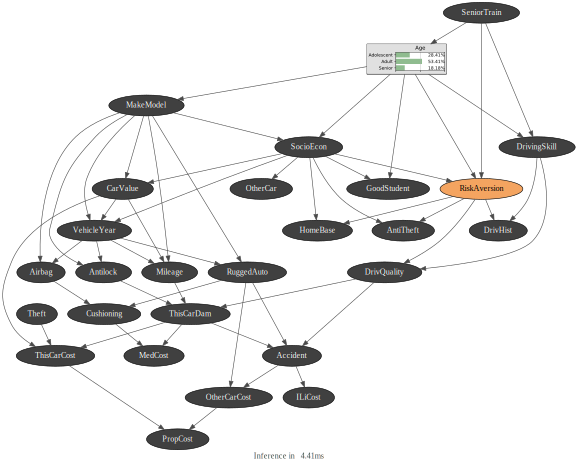

In [10]:
res = gnb.showInference(model = bn, engine = gum.LazyPropagation(bn), evs = {"RiskAversion" : "Psychopath"}, targets = ["Age"], view = "graph")


In [11]:
#bn.cpt(1).variable(1).domain()

bn.variableFromName("Age").labels()

('Adolescent', 'Adult', 'Senior')

In [12]:
ie=gum.LazyPropagation(bn)
#ie.makeInference()
ie.addEvidence("RiskAversion","Cautious")
ie.addJointTarget(set(["Accident", "ILiCost"]))
print(ie.jointPosterior(set(["Accident", "ILiCost"])))


      ||  Accident                             |
ILiCos||Mild     |Moderate |None     |Severe   |
------||---------|---------|---------|---------|
Hundre|| 0.0000  | 0.0017  | 0.0001  | 0.0047  |
Millio|| 0.0000  | 0.0011  | 0.0001  | 0.0040  |
TenTho|| 0.0001  | 0.0028  | 0.0001  | 0.0077  |
Thousa|| 0.0637  | 0.0480  | 0.8028  | 0.0631  |



In [13]:
l = np.unique(y_train.to_numpy())
print(sorted(l))

['Mild', 'Moderate', 'None', 'Severe']


In [16]:
def powerset(iterable):
    s = list(iterable)
    tmp = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    return tmp

In [18]:
def omega(variable, data) :
    return list(data[variable].unique())

In [19]:
omega("Age",X)

['Adult', 'Senior', 'Adolescent']

In [ ]:
def reduce_dataset(instance, X,y) :
    columns = X.columns
    for i,value in enumerate(instance) :
        if isinstance(value, str) or not math.isnan(value) :
            X = X[X[columns[i]] == value]
            X = X.drop(columns[i], axis=1)
    y = y[[j for j in y.index if j in X.index]]
    return X,y

In [ ]:
bn.dag().dSeparation(bn.nodeset(["DrivHist"]),bn.nodeset(["CarValue"]),bn.nodeset(["DrivingSkill", "RiskAversion"]))
bn_pr = prune_network(bn, ["DrivingSkill", "RiskAversion"], ["DrivHist"])
#bn_pr.names()

In [23]:
def prune_network(bn, ev_vars, hyp_vars, supp_vars = None) :
    #IMPORTANT: Hard copy of the bn
    bn_pr = gum.BayesNet(bn)
    # Find supplementary nodes of a network if not given
    
    if supp_vars is None :
        supp_vars = []
        for i in bn_pr.names() :
            if not i in ev_vars and not i in hyp_vars :
                supp_vars.append(i)
    # Delete from the network the nodes that are conditionally independent from the hypothesis variables (target) given the evidence
    dsep_nodes = []
    for i in supp_vars :
        if bn_pr.dag().dSeparation(bn_pr.nodeset([i]),bn_pr.nodeset(hyp_vars),bn_pr.nodeset(ev_vars)):
            dsep_nodes.append(i)
            bn_pr.erase(i)
    return bn_pr, dsep_nodes

def map_query(bn, ev_vars, hyp_vars) :
    ie=gum.LazyPropagation(bn)
    ie.addJointTarget(set(hyp_vars))
    ie.setEvidence(ev_vars)
    ie.makeInference()
    return ie.jointPosterior(set(hyp_vars))
            
    
def omega(variables, data = None , bn = None) :
    domains = []
    if bn is not None :
        for variable in variables :
            domains.append(sorted(bn.variableFromName(variable).labels()))
    else :
        for variable in variables :
            domains.append(sorted(data[variable].unique()))
    return [p for p in product(*domains)]
    

def prepare_mapi(instances, variables) :
     #Type checking
    if isinstance(instances, pd.core.frame.DataFrame) :
        instances = instances.to_numpy()
    #Array for each instance
    evidence_set = []
    # For each instance:
    for instance in instances :
        # Check which are the evidence variables
        evidence = dict()
        for i,value in enumerate(instance) :
            if isinstance(value, str) or not math.isnan(value) :
                evidence[variables[i]] = value
        evidence_set.append(evidence)
    return evidence_set
    

# True if R is relevant/MAP-dependent
# False if R is irrelevant/MAP-independent
def map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None) : 
    # Check which are the supplementary (missing) variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
    # Check if R in unobserved
    #print(supp_vars)
    for R in set_R :
        if R not in supp_vars :
            print("Error, the variables", R, "is in the set R but is not a supplementary node")
            return
    y = hyp_vars_assign
    if y is None :    
        # Perform a MAP-query and get the argmax from the posterior
        posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
        y = posterior.argmax()[0][0]
    # Obtain domain of R
    omega_R = omega(set_R, bn = bn)
    # For each value assignment r in omega(R)
    for value_assignment_r in omega_R :
        # Fill in values
        ev_vars_alt = ev_vars.copy()
        for i,value in enumerate(value_assignment_r) :
            ev_vars_alt[set_R[i]] = value
        #print(instance)
        #print(instance_alt)
        # Inference with evidence and r
        posterior_alt = map_query(bn, ev_vars = ev_vars_alt, hyp_vars = hyp_vars)
        y_alt = posterior_alt.argmax()[0][0]
        # Comparar con prediccion de instance
        print(value_assignment_r)
        print(y, " == ", y_alt)
        print(posterior.argmax()[1], "--", posterior_alt.argmax()[1])
        if y != y_alt :
            return True
    return False
    
def map_independence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = None) : 
    return not map_dependence(bn, set_R, ev_vars, hyp_vars, hyp_vars_assign = hyp_vars_assign)

In [24]:
map_query(bn, ev_vars = {'RiskAversion':"Psychopath"}, hyp_vars = ["Accident"]).argmax()[0][0]

{'Accident': 2}

In [25]:
map_independence(bn, ["ILiCost"], {'RiskAversion':"Psychopath"}, ["Accident"])

('HundredThou',)
{'Accident': 2}  ==  {'Accident': 3}
0.538795934472561 -- 0.7434004474866849


False

In [27]:
prepare_mapi(prueba, X_train.columns)

[{'GoodStudent': False,
  'Age': 'Senior',
  'SocioEcon': 'Middle',
  'RiskAversion': 'Cautious',
  'VehicleYear': 'Older',
  'ThisCarDam': 'None',
  'RuggedAuto': 'EggShell',
  'MakeModel': 'Economy',
  'DrivQuality': 'Normal',
  'Mileage': 'FiftyThou',
  'Antilock': False,
  'DrivingSkill': 'Normal',
  'SeniorTrain': True,
  'ThisCarCost': 'Thousand',
  'Theft': False,
  'CarValue': 'FiveThou',
  'HomeBase': 'Secure',
  'AntiTheft': True,
  'PropCost': 'TenThou',
  'OtherCarCost': 'Thousand'}]

In [28]:
omega(["RiskAversion", "DrivingSkill"], bn = bn)

[('Adventurous', 'Expert'),
 ('Adventurous', 'Normal'),
 ('Adventurous', 'SubStandard'),
 ('Cautious', 'Expert'),
 ('Cautious', 'Normal'),
 ('Cautious', 'SubStandard'),
 ('Normal', 'Expert'),
 ('Normal', 'Normal'),
 ('Normal', 'SubStandard'),
 ('Psychopath', 'Expert'),
 ('Psychopath', 'Normal'),
 ('Psychopath', 'SubStandard')]

In [87]:
def check_every_r_bn(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_nodes = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_nodes)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_nodes :
            supp_vars.append(i)
    
    S = powerset(supp_vars)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    for i in range(0,len(S_split)) :
        if i < depth :
            for j in S_split[i] :
                # If relevant
                print(list(j))
                if map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                    relevant_sets.append(j)
                    # Apply prune
                    for k in range(i+1,len(S_split)) :
                        tmp = []
                        for l in S_split[k] :
                            if set(j).issubset(set(l)) :
                                relevant_sets.append(l)
                            else :
                                tmp.append(l)
                        S_split[k] = tmp
                # If irrelevant
                else :
                    irrelevant_sets.append(j)
    return relevant_sets, irrelevant_sets, dsep_nodes

In [84]:
def check_every_r_silja(bn, ev_vars, hyp_vars, depth = np.inf) :
    # Check which are the supplementary variables
    variables = bn.names()
    supp_vars = []
    for var in variables :
        if var not in list(ev_vars.keys()) and var not in hyp_vars :
            supp_vars.append(var)
            
    # Delete the ones conditionally independent
    bn_pr, dsep_nodes = prune_network(bn, list(ev_vars.keys()), hyp_vars, supp_vars = supp_vars) 
    #print(dsep_nodes)
    
    tmp = supp_vars
    supp_vars = []
    
    for i in tmp :
        if i not in dsep_nodes :
            supp_vars.append(i)
    
    S = powerset(supp_vars)
    S.pop(0)
    # Divide by length
    S_split = []
    size = 0
    for i in S :
        if len(i) != size:
            size = size + 1
            S_split.append([])
        S_split[-1].append(i)
        
    # Variables to store relevant/irrelevant sets
    relevant_sets = []
    irrelevant_sets = []
    
    # Get the posterior and the argmax from the original MAP-query
    posterior = map_query(bn, ev_vars = ev_vars, hyp_vars = hyp_vars)
    y = posterior.argmax()[0][0]
    
    for i in range(0,len(S_split)) :
        if i < depth :
            if i == 0 :
                #smth
                
            else : 
                for j in S_split[i] :
                    # If relevant
                    print(list(j))
                    if map_dependence(bn_pr, set_R = list(j), ev_vars = ev_vars, hyp_vars = hyp_vars, hyp_vars_assign=y) :
                        relevant_sets.append(j)
                        # Apply prune
                        for k in range(i+1,len(S_split)) :
                            tmp = []
                            for l in S_split[k] :
                                if set(j).issubset(set(l)) :
                                    relevant_sets.append(l)
                                else :
                                    tmp.append(l)
                            S_split[k] = tmp
                    # If irrelevant
                    else :
                        irrelevant_sets.append(j)
    return relevant_sets, irrelevant_sets, dsep_nodes

In [83]:
ev_vars = {'RiskAversion':"Psychopath"}
hyp_vars = ["Accident"]
joint_target = list(ev_vars.keys()) + hyp_vars
ie=gum.LazyPropagation(bn)
ie.makeInference()
#joint_target = ["Accident", "ILiCost", "RiskAversion"]
ie.addJointTarget(set(joint_target))
#ie.setEvidence({"RiskAversion" : "Psychopath"})
post = ie.jointPosterior(set(joint_target))

In [85]:
print(post)
inst = gum.Instantiation(post)


      ||  Accident                             |
RiskAv||Mild     |Moderate |None     |Severe   |
------||---------|---------|---------|---------|
Advent|| 0.0312  | 0.0282  | 0.1577  | 0.0443  |
Cautio|| 0.0153  | 0.0128  | 0.1915  | 0.0189  |
Normal|| 0.0398  | 0.0343  | 0.3586  | 0.0522  |
Psycho|| 0.0021  | 0.0019  | 0.0082  | 0.0030  |



In [97]:
bn.variableFromName("ILiCost").domainSize()

4

In [89]:
inst.add(bn.variableFromName("ILiCost"))

OperationNotAllowed: [pyAgrum] Operation not allowed: in slave Instantiation

In [92]:
inst2 = gum.Instantiation()
inst2.add(bn.variableFromName("Accident"))

(pyAgrum.Instantiation@0x70467d0) <Accident:Mild>

In [94]:
post.get(inst2)

InvalidArgument: [pyAgrum] Invalid argument: RiskAversion not present in the instantiation <Accident:Mild>

In [80]:
print(inst)
#inst.setVals(["None", "Million", "Normal"])
inst.fromdict({"Accident" : "None", })
print(inst)

<Accident:Mild|RiskAversion:Adventurous|ILiCost:HundredThou>
<Accident:None|RiskAversion:Adventurous|ILiCost:HundredThou>


In [93]:
prueba = X_test.head(1).to_numpy()
prueba[0][0:16] = np.nan
t0 = time.time()
relevant_sets_p, irrelevant_sets_p, dsep_nodes = check_every_r_bn(bn, prepare_mapi(prueba, X_train.columns)[0] , ["Accident"], depth = 1)
tf = time.time()
print("Prune: ",tf-t0)

m::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', no destructor found.
swig/python detected a memory leak of type 'gum::NodeSet *', n

In [94]:
irrelevant_sets_p

[('SeniorTrain',),
 ('SocioEcon',),
 ('DrivingSkill',),
 ('GoodStudent',),
 ('RiskAversion',),
 ('Theft',),
 ('Mileage',),
 ('VehicleYear',),
 ('DrivQuality',),
 ('RuggedAuto',),
 ('CarValue',),
 ('MakeModel',),
 ('Antilock',),
 ('Age',)]

In [152]:
print(X_test)

       GoodStudent     Age    SocioEcon RiskAversion VehicleYear ThisCarDam  \
10628        False  Senior        Prole     Cautious       Older       None   
10981        False   Adult        Prole       Normal       Older       None   
3406         False  Senior      Wealthy     Cautious       Older       None   
18325        False  Senior  UpperMiddle     Cautious       Older       None   
18598        False   Adult  UpperMiddle       Normal     Current       None   
...            ...     ...          ...          ...         ...        ...   
15330        False   Adult        Prole     Cautious       Older       None   
6060         False  Senior       Middle  Adventurous     Current       None   
9530         False   Adult       Middle       Normal       Older   Moderate   
12813        False   Adult        Prole       Normal       Older       None   
16704        False   Adult       Middle       Normal       Older     Severe   

      RuggedAuto    MakeModel DrivQuality     Milea

In [ ]:
prueba = X_test.head(1).to_numpy()
prueba[0][0:10] = np.nan
t0 = time.time()
relevant_sets, irrelevant_sets = check_every_r(prueba, X_train)
tf = time.time()
print("Brute force: ",tf-t0)

In [ ]:
t0 = time.time()
relevant_sets_p, irrelevant_sets_p = check_every_r_prune(prueba, X_train)
tf = time.time()
print("Prune: ",tf-t0)

In [ ]:
print(relevant_sets == relevant_sets_p)
print(irrelevant_sets == irrelevant_sets_p)

In [146]:
irrelevant_sets_p

[('Airbag',),
 ('DrivHist',),
 ('Cushioning',),
 ('OtherCar',),
 ('MedCost',),
 ('ILiCost',),
 ('Airbag', 'DrivHist'),
 ('Airbag', 'Cushioning'),
 ('Airbag', 'OtherCar'),
 ('Airbag', 'MedCost'),
 ('Airbag', 'ILiCost'),
 ('DrivHist', 'Cushioning'),
 ('DrivHist', 'OtherCar'),
 ('DrivHist', 'MedCost'),
 ('DrivHist', 'ILiCost'),
 ('Cushioning', 'OtherCar'),
 ('Cushioning', 'MedCost'),
 ('Cushioning', 'ILiCost'),
 ('OtherCar', 'MedCost'),
 ('OtherCar', 'ILiCost'),
 ('MedCost', 'ILiCost'),
 ('Airbag', 'DrivHist', 'Cushioning'),
 ('Airbag', 'DrivHist', 'OtherCar'),
 ('Airbag', 'DrivHist', 'MedCost'),
 ('Airbag', 'DrivHist', 'ILiCost'),
 ('Airbag', 'Cushioning', 'OtherCar'),
 ('Airbag', 'Cushioning', 'MedCost'),
 ('Airbag', 'Cushioning', 'ILiCost'),
 ('Airbag', 'OtherCar', 'MedCost'),
 ('Airbag', 'OtherCar', 'ILiCost'),
 ('Airbag', 'MedCost', 'ILiCost'),
 ('DrivHist', 'Cushioning', 'OtherCar'),
 ('DrivHist', 'Cushioning', 'MedCost'),
 ('DrivHist', 'Cushioning', 'ILiCost'),
 ('DrivHist', 'Other

In [ ]:
# TODO FSS
X_red, y_red = reduce_dataset(prueba[0], X_train, y_train)

In [ ]:
X_red

In [ ]:
y_red

In [ ]:
#sel = feature_selection.GenericUnivariateSelect()
oe = preprocessing.OrdinalEncoder()
sel = feature_selection.RFECV(svm.SVC(kernel="linear"))
sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.support_

In [ ]:
print(X_red.columns[sel.support_ == False])

In [ ]:
feature_selection.mutual_info_classif(oe.fit_transform(X_red),y_red)

In [ ]:
sel = feature_selection.GenericUnivariateSelect(feature_selection.chi2)
X_new = sel.fit_transform(oe.fit_transform(X_red),y_red)
sel.get_support()

In [17]:
import sklearn
from pgmpy import estimators, models

In [39]:
# Structure learning
scoring_method = estimators.K2Score(data=app)
est = estimators.HillClimbSearch(data=app)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2*5)
)
#sklearn.metrics.get_f1_score(estimated_model, model)

  0%|          | 0/500 [00:00<?, ?it/s]

In [40]:
# Parameter learning
example = models.BayesianNetwork(estimated_model)
example.fit(app)

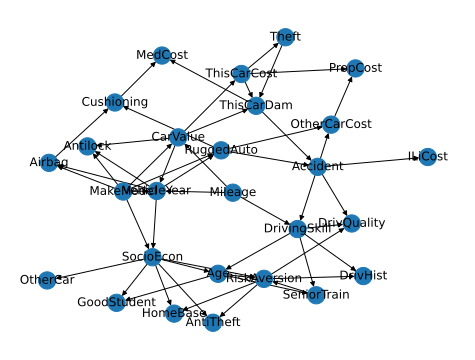

In [41]:
from pgmpy.models import BayesianModel
import networkx as nx
import pylab as plt
pos = nx.nx_agraph.graphviz_layout(example)
nx.draw(example, pos=pos, with_labels=True)
plt.show()

In [ ]:
type(example)

In [ ]:
bm = pgmpy.models.BayesianModel(example)